In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class ConvNeXt_AudioClassifier(nn.Module):
    def __init__(self, num_classes, input_channels=1, pretrained=False):
        super().__init__()
        
        # THAY ĐỔI 1: Tải kiến trúc ConvNeXt-Tiny với weights=None
        weights = models.ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
        self.convnext = models.convnext_tiny(weights=weights)

        # 1. Điều chỉnh lớp Conv đầu tiên (stem) để chấp nhận đầu vào 1 kênh
        original_stem = self.convnext.features[0][0]
        new_stem = nn.Conv2d(
            in_channels=input_channels,
            out_channels=original_stem.out_channels,
            kernel_size=original_stem.kernel_size,
            stride=original_stem.stride,
            padding=original_stem.padding,
            bias=False
        )
        self.convnext.features[0][0] = new_stem

        # 2. Thay thế lớp phân loại cuối cùng (head)
        num_ftrs = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.convnext(x)


def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [4]:
class InsectSpectrogramDataset(Dataset):
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1

In [5]:
METADATA_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\metadata_Mel.csv'
DATA_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\MelSpectrograms'

In [6]:
class TimeShift(torch.nn.Module):
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

train_transform = T.Compose([
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    TimeShift(p=0.5, max_shift_percent=0.4),
    SpecNoise(p=0.3, noise_level=0.03),
])

val_transform = None

def mixup_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device if use_cuda else 'cpu')
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # ConvNeXt có thể tốn nhiều VRAM hơn, giảm BATCH_SIZE nếu cần
    BATCH_SIZE = 32 
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [8]:
EPOCHS = 100

LEARNING_RATE = 0.001 
WEIGHT_DECAY = 1e-4


CHECKPOINT_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny'
LOG_CSV_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_convnext_tiny.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Khởi tạo mô hình mới
model = ConvNeXt_AudioClassifier(num_classes=num_classes, pretrained=False).to(device)
total_params, trainable_params = count_parameters(model)
print(f"Khởi tạo mô hình ConvNeXt-Tiny (từ đầu) với {total_params/1e6:.2f}M tham số.")


# --- PHẦN CÒN LẠI CỦA CODE (OPTIMIZER, SCHEDULER, TRAINING LOOP) GIỮ NGUYÊN ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

log_header = ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy', 'precision', 'recall', 'f1']
with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

Khởi tạo mô hình ConvNeXt-Tiny (từ đầu) với 27.83M tham số.


In [9]:
print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

best_val_f1 = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in progress_bar:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss   = val_loss / len(val_dataset)
    accuracy  = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall    = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    f1        = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    log_data = [epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy, precision, recall, f1]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_data)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny' và log tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_convnext_tiny.csv'


Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.5646 | Val Loss: 1.0409
  Accuracy: 0.6347 | Precision: 0.6347 | Recall: 0.6347 | F1: 0.6347
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.6347)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.1219 | Val Loss: 0.7908
  Accuracy: 0.7280 | Precision: 0.7280 | Recall: 0.7280 | F1: 0.7280
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.7280)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 0.9837 | Val Loss: 0.6943
  Accuracy: 0.7579 | Precision: 0.7579 | Recall: 0.7579 | F1: 0.7579
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.7579)



Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.8849 | Val Loss: 0.6048
  Accuracy: 0.7884 | Precision: 0.7884 | Recall: 0.7884 | F1: 0.7884
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.7884)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8343 | Val Loss: 0.5916
  Accuracy: 0.7919 | Precision: 0.7919 | Recall: 0.7919 | F1: 0.7919
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.7919)



Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.7695 | Val Loss: 0.5452
  Accuracy: 0.8099 | Precision: 0.8099 | Recall: 0.8099 | F1: 0.8099
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8099)



Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7124 | Val Loss: 0.5079
  Accuracy: 0.8232 | Precision: 0.8232 | Recall: 0.8232 | F1: 0.8232
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8232)



Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.6812 | Val Loss: 0.4743
  Accuracy: 0.8368 | Precision: 0.8368 | Recall: 0.8368 | F1: 0.8368
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8368)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6328 | Val Loss: 0.4838
  Accuracy: 0.8325 | Precision: 0.8325 | Recall: 0.8325 | F1: 0.8325


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.5976 | Val Loss: 0.4924
  Accuracy: 0.8341 | Precision: 0.8341 | Recall: 0.8341 | F1: 0.8341


Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.5504 | Val Loss: 0.4970
  Accuracy: 0.8424 | Precision: 0.8424 | Recall: 0.8424 | F1: 0.8424
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8424)



Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.5188 | Val Loss: 0.4838
  Accuracy: 0.8466 | Precision: 0.8466 | Recall: 0.8466 | F1: 0.8466
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8466)



Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.4800 | Val Loss: 0.6141
  Accuracy: 0.8231 | Precision: 0.8231 | Recall: 0.8231 | F1: 0.8231


Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.4718 | Val Loss: 0.5556
  Accuracy: 0.8386 | Precision: 0.8386 | Recall: 0.8386 | F1: 0.8386


Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.4494 | Val Loss: 0.5438
  Accuracy: 0.8384 | Precision: 0.8384 | Recall: 0.8384 | F1: 0.8384


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.4227 | Val Loss: 0.5971
  Accuracy: 0.8419 | Precision: 0.8419 | Recall: 0.8419 | F1: 0.8419


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.4040 | Val Loss: 0.5688
  Accuracy: 0.8396 | Precision: 0.8396 | Recall: 0.8396 | F1: 0.8396


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.4040 | Val Loss: 0.6234
  Accuracy: 0.8386 | Precision: 0.8386 | Recall: 0.8386 | F1: 0.8386


Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.3944 | Val Loss: 0.6105
  Accuracy: 0.8422 | Precision: 0.8422 | Recall: 0.8422 | F1: 0.8422


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.3814 | Val Loss: 0.6402
  Accuracy: 0.8391 | Precision: 0.8391 | Recall: 0.8391 | F1: 0.8391


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.3811 | Val Loss: 0.5908
  Accuracy: 0.8429 | Precision: 0.8429 | Recall: 0.8429 | F1: 0.8429


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.3823 | Val Loss: 0.6442
  Accuracy: 0.8414 | Precision: 0.8414 | Recall: 0.8414 | F1: 0.8414


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.3689 | Val Loss: 0.6515
  Accuracy: 0.8395 | Precision: 0.8395 | Recall: 0.8395 | F1: 0.8395


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.3522 | Val Loss: 0.6470
  Accuracy: 0.8391 | Precision: 0.8391 | Recall: 0.8391 | F1: 0.8391


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.3527 | Val Loss: 0.6785
  Accuracy: 0.8363 | Precision: 0.8363 | Recall: 0.8363 | F1: 0.8363


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.3637 | Val Loss: 0.7825
  Accuracy: 0.8386 | Precision: 0.8386 | Recall: 0.8386 | F1: 0.8386


Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.3582 | Val Loss: 0.6416
  Accuracy: 0.8381 | Precision: 0.8381 | Recall: 0.8381 | F1: 0.8381


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.3427 | Val Loss: 0.7080
  Accuracy: 0.8425 | Precision: 0.8425 | Recall: 0.8425 | F1: 0.8425


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.3486 | Val Loss: 0.7324
  Accuracy: 0.8364 | Precision: 0.8364 | Recall: 0.8364 | F1: 0.8364


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.3503 | Val Loss: 0.7097
  Accuracy: 0.8406 | Precision: 0.8406 | Recall: 0.8406 | F1: 0.8406


Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.3393 | Val Loss: 0.7570
  Accuracy: 0.8356 | Precision: 0.8356 | Recall: 0.8356 | F1: 0.8356


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.3380 | Val Loss: 0.7358
  Accuracy: 0.8415 | Precision: 0.8415 | Recall: 0.8415 | F1: 0.8415


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.3376 | Val Loss: 0.6602
  Accuracy: 0.8385 | Precision: 0.8385 | Recall: 0.8385 | F1: 0.8385


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.3444 | Val Loss: 0.7280
  Accuracy: 0.8405 | Precision: 0.8405 | Recall: 0.8405 | F1: 0.8405


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.3224 | Val Loss: 0.7531
  Accuracy: 0.8406 | Precision: 0.8406 | Recall: 0.8406 | F1: 0.8406


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3317 | Val Loss: 0.7109
  Accuracy: 0.8443 | Precision: 0.8443 | Recall: 0.8443 | F1: 0.8443


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3215 | Val Loss: 0.7492
  Accuracy: 0.8434 | Precision: 0.8434 | Recall: 0.8434 | F1: 0.8434


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3227 | Val Loss: 0.7256
  Accuracy: 0.8448 | Precision: 0.8448 | Recall: 0.8448 | F1: 0.8448


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3264 | Val Loss: 0.7820
  Accuracy: 0.8447 | Precision: 0.8447 | Recall: 0.8447 | F1: 0.8447


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3218 | Val Loss: 0.7043
  Accuracy: 0.8468 | Precision: 0.8468 | Recall: 0.8468 | F1: 0.8468
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8468)



Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3201 | Val Loss: 0.6825
  Accuracy: 0.8427 | Precision: 0.8427 | Recall: 0.8427 | F1: 0.8427


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3123 | Val Loss: 0.8189
  Accuracy: 0.8411 | Precision: 0.8411 | Recall: 0.8411 | F1: 0.8411


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3112 | Val Loss: 0.7216
  Accuracy: 0.8462 | Precision: 0.8462 | Recall: 0.8462 | F1: 0.8462


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3093 | Val Loss: 0.7463
  Accuracy: 0.8455 | Precision: 0.8455 | Recall: 0.8455 | F1: 0.8455


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3102 | Val Loss: 0.7733
  Accuracy: 0.8423 | Precision: 0.8423 | Recall: 0.8423 | F1: 0.8423


Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3166 | Val Loss: 0.6684
  Accuracy: 0.8466 | Precision: 0.8466 | Recall: 0.8466 | F1: 0.8466


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3037 | Val Loss: 0.7397
  Accuracy: 0.8447 | Precision: 0.8447 | Recall: 0.8447 | F1: 0.8447


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3064 | Val Loss: 0.7299
  Accuracy: 0.8478 | Precision: 0.8478 | Recall: 0.8478 | F1: 0.8478
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8478)



Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.2919 | Val Loss: 0.7346
  Accuracy: 0.8485 | Precision: 0.8485 | Recall: 0.8485 | F1: 0.8485
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8485)



Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.2951 | Val Loss: 0.7766
  Accuracy: 0.8436 | Precision: 0.8436 | Recall: 0.8436 | F1: 0.8436


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3072 | Val Loss: 0.7765
  Accuracy: 0.8439 | Precision: 0.8439 | Recall: 0.8439 | F1: 0.8439


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3081 | Val Loss: 0.7933
  Accuracy: 0.8478 | Precision: 0.8478 | Recall: 0.8478 | F1: 0.8478


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.2959 | Val Loss: 0.7938
  Accuracy: 0.8442 | Precision: 0.8442 | Recall: 0.8442 | F1: 0.8442


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.2940 | Val Loss: 0.7819
  Accuracy: 0.8400 | Precision: 0.8400 | Recall: 0.8400 | F1: 0.8400


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.2918 | Val Loss: 0.8173
  Accuracy: 0.8474 | Precision: 0.8474 | Recall: 0.8474 | F1: 0.8474


Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3037 | Val Loss: 0.7693
  Accuracy: 0.8473 | Precision: 0.8473 | Recall: 0.8473 | F1: 0.8473


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.2861 | Val Loss: 0.8056
  Accuracy: 0.8479 | Precision: 0.8479 | Recall: 0.8479 | F1: 0.8479


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.2971 | Val Loss: 0.8267
  Accuracy: 0.8474 | Precision: 0.8474 | Recall: 0.8474 | F1: 0.8474


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.2828 | Val Loss: 0.7700
  Accuracy: 0.8518 | Precision: 0.8518 | Recall: 0.8518 | F1: 0.8518
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8518)



Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3026 | Val Loss: 0.7454
  Accuracy: 0.8500 | Precision: 0.8500 | Recall: 0.8500 | F1: 0.8500


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.2802 | Val Loss: 0.7546
  Accuracy: 0.8510 | Precision: 0.8510 | Recall: 0.8510 | F1: 0.8510


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.2824 | Val Loss: 0.7355
  Accuracy: 0.8512 | Precision: 0.8512 | Recall: 0.8512 | F1: 0.8512


Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.2792 | Val Loss: 0.8264
  Accuracy: 0.8523 | Precision: 0.8523 | Recall: 0.8523 | F1: 0.8523
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8523)



Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.2836 | Val Loss: 0.7839
  Accuracy: 0.8506 | Precision: 0.8506 | Recall: 0.8506 | F1: 0.8506


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.2794 | Val Loss: 0.8045
  Accuracy: 0.8497 | Precision: 0.8497 | Recall: 0.8497 | F1: 0.8497


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.2840 | Val Loss: 0.7986
  Accuracy: 0.8489 | Precision: 0.8489 | Recall: 0.8489 | F1: 0.8489


Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.2834 | Val Loss: 0.8164
  Accuracy: 0.8513 | Precision: 0.8513 | Recall: 0.8513 | F1: 0.8513


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.2853 | Val Loss: 0.7602
  Accuracy: 0.8505 | Precision: 0.8505 | Recall: 0.8505 | F1: 0.8505


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.2820 | Val Loss: 0.8631
  Accuracy: 0.8516 | Precision: 0.8516 | Recall: 0.8516 | F1: 0.8516


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.2839 | Val Loss: 0.7533
  Accuracy: 0.8519 | Precision: 0.8519 | Recall: 0.8519 | F1: 0.8519


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.2753 | Val Loss: 0.8737
  Accuracy: 0.8525 | Precision: 0.8525 | Recall: 0.8525 | F1: 0.8525
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8525)



Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.2792 | Val Loss: 0.7920
  Accuracy: 0.8536 | Precision: 0.8536 | Recall: 0.8536 | F1: 0.8536
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8536)



Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.2769 | Val Loss: 0.7704
  Accuracy: 0.8555 | Precision: 0.8555 | Recall: 0.8555 | F1: 0.8555
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8555)



Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.2776 | Val Loss: 0.8098
  Accuracy: 0.8558 | Precision: 0.8558 | Recall: 0.8558 | F1: 0.8558
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8558)



Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.2901 | Val Loss: 0.8021
  Accuracy: 0.8563 | Precision: 0.8563 | Recall: 0.8563 | F1: 0.8563
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8563)



Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2703 | Val Loss: 0.8056
  Accuracy: 0.8549 | Precision: 0.8549 | Recall: 0.8549 | F1: 0.8549


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.2859 | Val Loss: 0.8110
  Accuracy: 0.8534 | Precision: 0.8534 | Recall: 0.8534 | F1: 0.8534


Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.2780 | Val Loss: 0.8231
  Accuracy: 0.8578 | Precision: 0.8578 | Recall: 0.8578 | F1: 0.8578
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8578)



Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2629 | Val Loss: 0.8175
  Accuracy: 0.8554 | Precision: 0.8554 | Recall: 0.8554 | F1: 0.8554


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2739 | Val Loss: 0.7870
  Accuracy: 0.8569 | Precision: 0.8569 | Recall: 0.8569 | F1: 0.8569


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2822 | Val Loss: 0.7796
  Accuracy: 0.8557 | Precision: 0.8557 | Recall: 0.8557 | F1: 0.8557


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2721 | Val Loss: 0.7923
  Accuracy: 0.8550 | Precision: 0.8550 | Recall: 0.8550 | F1: 0.8550


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2717 | Val Loss: 0.8265
  Accuracy: 0.8553 | Precision: 0.8553 | Recall: 0.8553 | F1: 0.8553


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2686 | Val Loss: 0.8121
  Accuracy: 0.8571 | Precision: 0.8571 | Recall: 0.8571 | F1: 0.8571


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2620 | Val Loss: 0.7948
  Accuracy: 0.8567 | Precision: 0.8567 | Recall: 0.8567 | F1: 0.8567


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2615 | Val Loss: 0.8124
  Accuracy: 0.8579 | Precision: 0.8579 | Recall: 0.8579 | F1: 0.8579
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8579)



Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2683 | Val Loss: 0.8241
  Accuracy: 0.8563 | Precision: 0.8563 | Recall: 0.8563 | F1: 0.8563


Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2567 | Val Loss: 0.8011
  Accuracy: 0.8561 | Precision: 0.8561 | Recall: 0.8561 | F1: 0.8561


Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2572 | Val Loss: 0.7720
  Accuracy: 0.8559 | Precision: 0.8559 | Recall: 0.8559 | F1: 0.8559


Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2564 | Val Loss: 0.8143
  Accuracy: 0.8570 | Precision: 0.8570 | Recall: 0.8570 | F1: 0.8570


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2640 | Val Loss: 0.8063
  Accuracy: 0.8573 | Precision: 0.8573 | Recall: 0.8573 | F1: 0.8573


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2742 | Val Loss: 0.8053
  Accuracy: 0.8576 | Precision: 0.8576 | Recall: 0.8576 | F1: 0.8576


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2658 | Val Loss: 0.8114
  Accuracy: 0.8567 | Precision: 0.8567 | Recall: 0.8567 | F1: 0.8567


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2614 | Val Loss: 0.8099
  Accuracy: 0.8575 | Precision: 0.8575 | Recall: 0.8575 | F1: 0.8575


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2716 | Val Loss: 0.8072
  Accuracy: 0.8572 | Precision: 0.8572 | Recall: 0.8572 | F1: 0.8572


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2752 | Val Loss: 0.8123
  Accuracy: 0.8580 | Precision: 0.8580 | Recall: 0.8580 | F1: 0.8580
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_convnext_tiny\best_model.pth' (F1: 0.8580)



Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2748 | Val Loss: 0.8061
  Accuracy: 0.8578 | Precision: 0.8578 | Recall: 0.8578 | F1: 0.8578


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2719 | Val Loss: 0.8084
  Accuracy: 0.8577 | Precision: 0.8577 | Recall: 0.8577 | F1: 0.8577


Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2643 | Val Loss: 0.8089
  Accuracy: 0.8580 | Precision: 0.8580 | Recall: 0.8580 | F1: 0.8580


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2578 | Val Loss: 0.8124
  Accuracy: 0.8577 | Precision: 0.8577 | Recall: 0.8577 | F1: 0.8577

✅ Hoàn tất huấn luyện!


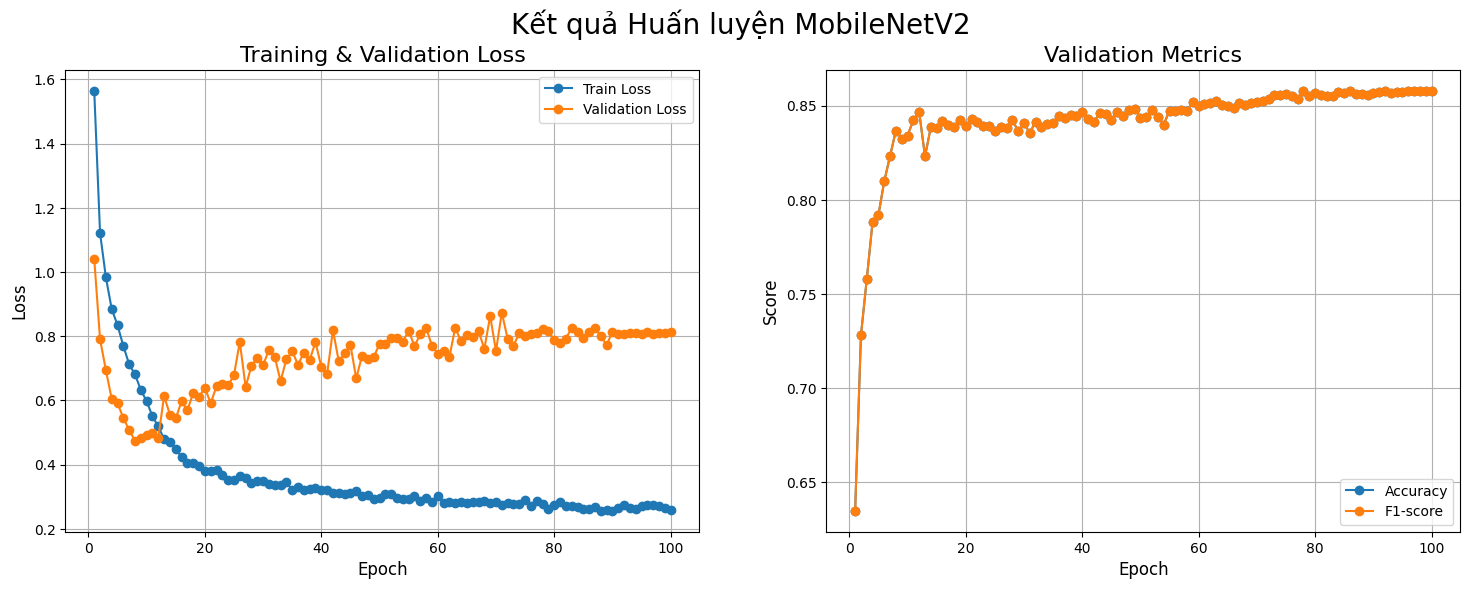


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


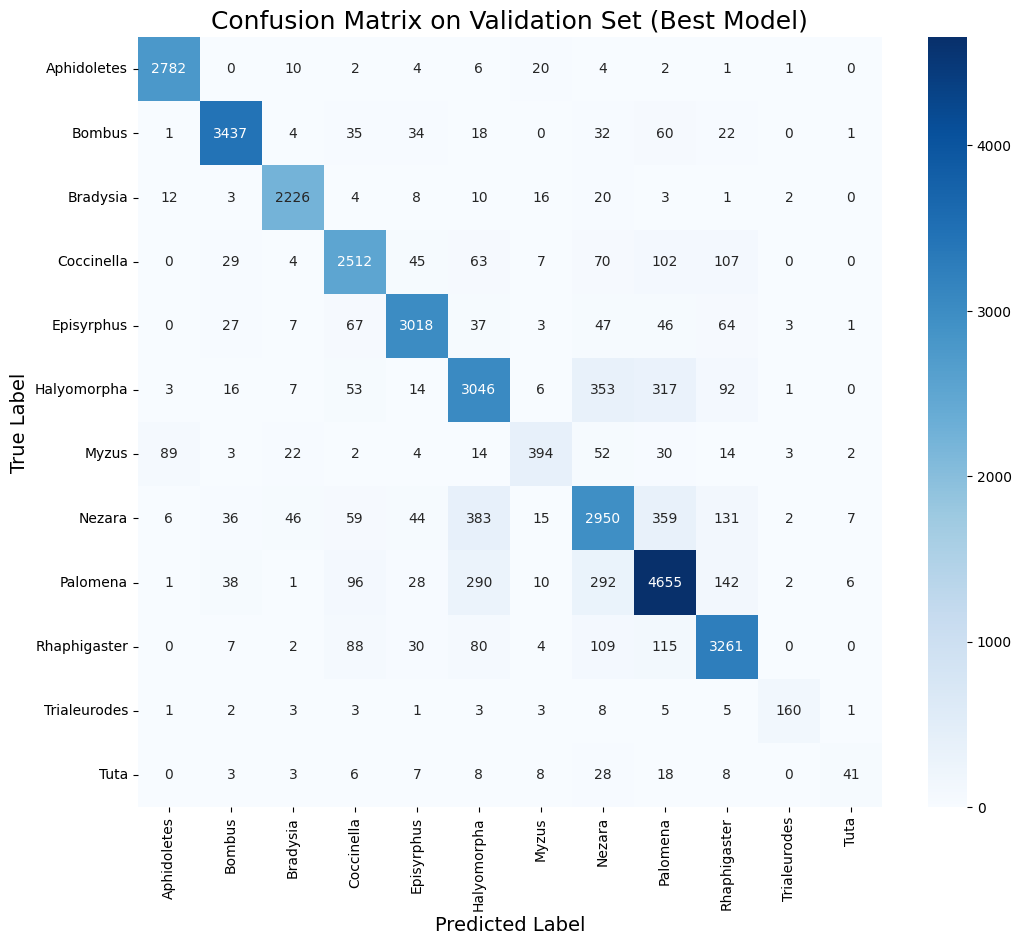

In [10]:
log_df = pd.read_csv(LOG_CSV_PATH)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['f1'], label='F1-score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện MobileNetV2', fontsize=20)
plt.show()

best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.class_names,
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

In [ ]:
dá